## Movie recommendations using item based collaborative filtering technique

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
print(sys.version)
print('pandas:',pd.__version__)
print('numpy:',np.__version__)

3.8.8 (default, Feb 24 2021, 13:46:16) 
[Clang 10.0.0 ]
pandas: 1.2.3
numpy: 1.19.2


### Read users rating and movies datasets

In [3]:
ratings = pd.read_csv('./ml-latest-small/ratings.csv')
print('Dataset contains {} ratings'.format(ratings.shape[0]))
ratings.head()

Dataset contains 100836 ratings


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
movies = pd.read_csv('./ml-latest-small/movies.csv')
print('Dataset contains {} movies'.format(movies.shape[0]))
movies.head()

Dataset contains 9742 movies


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings = pd.merge(movies, ratings) # merge two dataframs to add movie titles
ratings.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


#### Delete timestamp and genres for now, maybe I'll use them later for better predictions

In [6]:
del ratings['timestamp']
del ratings['genres']

### Pivot this data frame by creating a new one:
* user ids are the rows 
* movie titles are the columns
* values are users ratings, many missing values here since we do not expect that every user watched and rated all movies

In [7]:
user_ratings = ratings.pivot_table(index=['userId'],columns=['title'],values='rating')
print('The new datafram has {} users (rows) who rated {} movies (columns).'.format(user_ratings.shape[0],user_ratings.shape[1]))
user_ratings.head()

The new datafram has 610 users (rows) who rated 9719 movies (columns).


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Filter out outliers, users who rated a large number of movies or users who rated 2 or less movies


In [8]:
def reject_outliers(counts,_max=None):
    ''' filter out users who rated more that median + one standard deviations 
        or users who rated 2 or less movies'''
    if _max is None:
        _max = int(np.median(counts) + np.std(counts))
        
    filtered = [e for e in counts if (e < _max)] 
    
    print('Filtering out %d users who rated more that %d movies...'%((len(counts) - len(filtered)),_max))
    return filtered

In [9]:
rating_counts = user_ratings.count(axis=1) #Count non-NA cells for each row.
print('Some stats on user rating counts...')
print('\tMin number of ratings = %d'%min(rating_counts))
print('\tMax number of ratings = %d'%max(rating_counts))
print('\tRatings mean= %.2f'%np.mean(rating_counts))
print('\tRatings standard deviation= %.2f'%np.std(rating_counts))

Some stats on user rating counts...
	Min number of ratings = 20
	Max number of ratings = 2698
	Ratings mean= 165.30
	Ratings standard deviation= 269.25


In [10]:
filtered_rating_counts = reject_outliers(rating_counts)
print('After filtering out outliers...')
print('\tMax number of ratings = %d'%max(filtered_rating_counts))
print('\tRatings mean= %.2f'%np.mean(filtered_rating_counts))
print('\tRatings standard deviation= %.2f'%np.std(filtered_rating_counts))

Filtering out 77 users who rated more that 339 movies...
After filtering out outliers...
	Max number of ratings = 334
	Ratings mean= 87.70
	Ratings standard deviation= 72.66


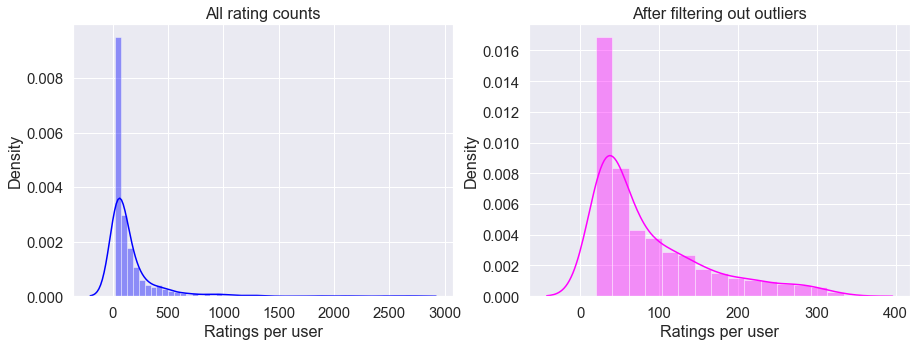

In [11]:
#plt.figure(dpi=620)                                                                                                        
sns.set(font_scale=1.35)
fig, axs = plt.subplots(1,2,figsize=(15, 5))
sns.distplot(rating_counts,color='blue',ax=axs[0])
axs[0].set_xlabel('Ratings per user')
axs[0].set_title('All rating counts')
sns.distplot(filtered_rating_counts,color='fuchsia',ax=axs[1])
axs[1].set_xlabel('Ratings per user')
axs[1].set_title('After filtering out outliers')
plt.show()

In [12]:
upper_thresh = 200
rows_before = user_ratings.shape[0]
user_ratings = user_ratings.loc[(user_ratings.count(axis=1) <= upper_thresh) & (user_ratings.count(axis=1) > 2)]
rows_after = user_ratings.shape[0]
print('Dropping {} users from user_ratings dataframe who ranked more than {} movies'.format((rows_before-rows_after),upper_thresh))

Dropping 133 users from user_ratings dataframe who ranked more than 200 movies


### Here, I manually add myself as a new user and I add my favourite movies to get recomenndations

In [13]:
#old_movies = ['shawshank redemption','forrest gump','groundhog day']
#new_movies = ['days of summer','eat pray love','me before you','la la land','pursuit of happyness']
# get movie ids which match the titles
my_movies = ['interstellar','inception','prestige']
for i in range(len(user_ratings.columns)):
    item = user_ratings.columns[i]
    for keyword in my_movies:
        if keyword in item.lower():
            print(i,user_ratings.columns[i])


4323 Inception (2010)
4396 Interstellar (2014)
6770 Prestige, The (2006)


In [14]:
my_ratings = [np.nan]*len(user_ratings.columns)
my_ratings[4323] = 4
my_ratings[6770] = 4
my_ratings[4396] = 5

In [15]:
new_id = user_ratings.index.max()+1
print(new_id)

610


In [16]:
user_ratings.loc[new_id] = my_ratings

#### Just sanity chekc!!

In [17]:
my_ratings = user_ratings.loc[new_id].dropna()
my_ratings

title
Inception (2010)        4.0
Interstellar (2014)     5.0
Prestige, The (2006)    4.0
Name: 610, dtype: float64

### Computing correlation score for every pair of columns, excluding NA/null values

#### I use min_period to consider a movie pair if and only if MIN_USERS users rated both movies, you can always change MIN_USERS, higher values make the prediction more conservative, lower values may make the predictions too general.. just play with it

In [18]:
?user_ratings.corr

In [19]:
MIN_USERS = 15 # for each pair of movies, the min number of users who ranked both of them
#min_periods option currently only available for Pearson and Spearman correlation.
corr_matrix = user_ratings.corr(method='pearson', min_periods=MIN_USERS)
corr_matrix

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Hellboy': The Seeds of Creation (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Round Midnight (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Salem's Lot (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xXx (2002),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xXx: State of the Union (2005),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
recommend_list = pd.Series(dtype='float64')
for i in range(0, len(my_ratings.index)):
    
    sim_movies = corr_matrix[my_ratings.index[i]].dropna() #get similar movies whose correlation score is non NaN
    sim_movies = sim_movies.map(lambda x: x * my_ratings[i]) # scale the score by my rating
    recommend_list = recommend_list.append(sim_movies)
    print ("There are %d movies which has correlation with %s..." %(len(sim_movies),my_ratings.index[i]))

print("\nGrouping and sorting recommendation results:")
recommend_list = recommend_list.groupby(recommend_list.index).sum() # some of the recommended movies will be redundant since it'll be similar to more than one movie in my list 
recommend_list = recommend_list.drop(my_ratings.index, errors='ignore')
recommend_list.sort_values(inplace = True, ascending = False)
recommend_list.head(15)

There are 98 movies which has correlation with Inception (2010)...
There are 30 movies which has correlation with Interstellar (2014)...
There are 41 movies which has correlation with Prestige, The (2006)...

Grouping and sorting recommendation results:


Schindler's List (1993)                                                           7.123010
Fight Club (1999)                                                                 6.914616
Matrix, The (1999)                                                                6.450796
Gladiator (2000)                                                                  6.043442
Star Wars: Episode V - The Empire Strikes Back (1980)                             6.042761
Godfather, The (1972)                                                             5.366474
Saving Private Ryan (1998)                                                        5.251430
Avengers, The (2012)                                                              5.091267
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)    4.905091
Pirates of the Caribbean: The Curse of the Black Pearl (2003)                     4.835682
Dark Knight Rises, The (2012)                                                     4.666484

### I enjoyed watching many of the movies on the recommendation list!


### <font color='blue'>To further improve the results:</font> 

* Scale user ratings, some users tend to be more genrous when rating a movie, others can be more conservative, one approach is to use MinMaxScaler from sklearn.preprocessing
* Split into train and test sets, construct correlation matrix from training data, hide sublest of movies in the test set and see if we can recommend the hidden movie list
* At the end, when enumerating the results, I scale the correlation score by movie rating (value between 1 and 5). An alternative approach is to map star rating to negative and positive scales {1_star: -2, 2_stars: -1, 3_stars: 0, 4_stars: 1, 5_stars: 2}.